# Bin 3-5 GC ML Models

Here, we'll try to apply machine learning models to the 3-5 GC bin occasion classification problem.

We've annotated just about 90 tables of 3-5 guests with occasions, nothing much but we'll try to use it with our (semi-/)supervised models.

-----------

## Prepare the data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
data_map = {
    "hockey"    : "../data/hockey_processed_tables.csv",
    "valentine" : "../data/valentine_processed_tables.csv",
    "silvester" : "../data/silvester_processed_tables.csv"
}

Read tables data:

In [3]:
columns = [
    "order_id",
    "order_hour",
    #"order_minute",
    "order_close_hour",
    #"order_close_minute",
    "period_of_day",
    "order_day_of_week",
    "is_weekend",
    "item_qty",
    "beer_volume",
    "guest_count",
    "total_orders_category_id_1.0",
    "total_orders_category_id_2.0",
    "total_orders_category_id_3.0",
    "total_orders_category_id_4.0",
    "total_orders_category_id_5.0",
    "total_orders_category_id_6.0",
    "total_orders",
    "total_large_meals",
    "total_small_meals",
    "total_large_sharable_meals",
    "total_small_sharable_meals",
    "sharable",
    "kids_meal",
    "birthday",
    "dwell_time",
    "meal_flow_last_to_close",
    "total_flow_steps",
    "total_meal_steps",
    "avg_time_between_steps",
    "sit_to_order",
    "max_items_per_step",
    "total_sales_before_tax"#,
    #"total_sales_inc_tax"
]

In [4]:
df = {}
df_orig = {}

for table in data_map.keys():
    df[table] = pd.read_csv(data_map[table], usecols=columns)
    df_orig[table] = pd.read_csv(data_map[table], usecols=columns)

df = pd.concat([df[table] for table in data_map.keys()])
df_orig = pd.concat([df_orig[table] for table in data_map.keys()])

Keep 3-5 guests tables only:

In [5]:
print(df.shape)

(243755, 31)


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 243755 entries, 0 to 88995
Data columns (total 31 columns):
order_id                        243755 non-null int64
order_hour                      243755 non-null int64
order_close_hour                243755 non-null int64
period_of_day                   243755 non-null object
order_day_of_week               243755 non-null object
is_weekend                      243755 non-null bool
item_qty                        243755 non-null float64
beer_volume                     243755 non-null float64
guest_count                     243755 non-null int64
total_orders_category_id_1.0    243755 non-null float64
total_orders_category_id_2.0    243755 non-null float64
total_orders_category_id_3.0    243755 non-null float64
total_orders_category_id_4.0    243755 non-null float64
total_orders_category_id_5.0    243755 non-null float64
total_orders_category_id_6.0    243755 non-null float64
total_orders                    243755 non-null int64
total_lar

Keep 3-5 guests tables only:

In [7]:
df = df[(df['guest_count'] >= 3) & (df['guest_count'] <= 5)]

In [8]:
print(df.shape)

(32742, 31)


Get dummies for non-numeric (categorical) features:

In [9]:
df = pd.concat([df, pd.get_dummies(df["period_of_day"], prefix="period_of_day")], axis=1)
df = pd.concat([df, pd.get_dummies(df["order_day_of_week"], prefix="order_day_of_week")], axis=1)

In [10]:
df.drop(["period_of_day", "order_day_of_week"], axis=1, inplace=True)

In [11]:
print(df.shape)

(32742, 42)


Note we've dropped the non-numeric features.

Get labels:

In [12]:
labeled_tables_map = {
    "hockey": [
        (520803608, "LUNCH"),
        (523294848, "FAMILY_EVENT"),
        (514583822, "SOCIAL_GATHERING"),
        (524421347, "FAMILY_EVENT"),
        (521095118, "DRINKING"),
        (522574215, "FAMILY_EVENT"),
        (522779155, "DRINKING"),
        (515363895, "BREAKFAST"),
        (519501788, "FAMILY_EVENT"),
        (514529424, "SOCIAL_GATHERING"),
        (513486993, "LUNCH"),
        (522542767, "FAMILY_EVENT"),
        (523317944, "FAMILY_EVENT"),
        (520779953, "SOCIAL_GATHERING"),
        (514329317, "LUNCH"),
        (524196111, "LUNCH"),
        (525550553, "DINNER"),
        (519525238, "DINNER"),
        (513506080, "FAMILY_EVENT"),
        (520130914, "FAMILY_EVENT"),
        (523514188, "DINNER"),
        (523328731, "LUNCH"),
        (521804862, "DINNER"),
        (524442000, "DINNER"),
        (514472097, "FAMILY_EVENT"),
        (521770033, "DINNER"),
        (520119333, "DINNER"),
        (525397783, "LUNCH"),
        (511353667, "AFTER_WORK"),
        (522420188, "LUNCH")
    ],
    "valentine": [
        (447441456, "FAMILY_EVENT"),
        (435005397, "SOCIAL_GATHERING"),
        (435011399, "LUNCH"),
        (447381509, "LUNCH"),
        (446744761, "LUNCH"),
        (447079489, "DINNER"),
        (434609975, "FAMILY_EVENT"),
        (448041560, "DINNER"),
        (447074978, "AFTER_WORK"),
        (434603220, "LUNCH"),
        (446798723, "DINNER"),
        (448169651, "SOCIAL_GATHERING"),
        (434708231, "DINNER"),
        (447647574, "DRINKING"),
        (448003813, "FAMILY_EVENT"),
        (447986271, "FAMILY_EVENT"),
        (447020385, "LUNCH"),
        (447091085, "DINNER"),
        (435006071, "LUNCH"),
        (434752383, "SOCIAL_GATHERING"),
        (447523773, "FAMILY_EVENT"),
        (435067253, "DINNER"),
        (434617535, "DRINKING"),
        (447986377, "DINNER"),
        (447877104, "LUNCH"),
        (447558662, "FAMILY_EVENT"),
        (448008007, "FAMILY_EVENT"),
        (447497220, "DRINKING"),
        (435171863, "DINNER"),
        (447019409, "LUNCH")
    ],
    "silvester": [
        (362939931, "AFTER_WORK"),
        (361304992, "FAMILY_EVENT"),
        (363233153, "LUNCH"),
        (360790021, "LUNCH"),
        (362924064, "AFTER_WORK"),
        (361776660, "DINNER"),
        (361815160, "DINNER"),
        (360000762, "DINNER"),
        (360402335, "DINNER"),
        (361369624, "FAMILY_EVENT"),
        (363177655, "BREAKFAST"),
        (359978168, "FAMILY_EVENT"),
        (359644089, "SOCIAL_GATHERING"),
        (362094000, "BREAKFAST"),
        (361772528, "DINNER"),
        (359978861, "LUNCH"),
        (360862630, "SOCIAL_GATHERING"),
        (362626040, "AFTER_WORK"),
        (359970875, "LUNCH"),
        (363694039, "FAMILY_EVENT"),
        (361723648, "DINNER"),
        (360802830, "FAMILY_EVENT"),
        (360778622, "LUNCH"),
        (360543623, "LUNCH"),
        (363655255, "LUNCH"),
        (360057302, "DINNER"),
        (361881265, "DRINKING"),
        (360336485, "SOCIAL_GATHERING"),
        (359420117, "LUNCH"),
        (361326979, "FAMILY_EVENT")
    ]
}

In [13]:
labels = []

for table in data_map.keys():
    labels = labels + labeled_tables_map[table]

assert(len(labels) == 90)
print("Total of {} labeled tables.".format(len(labels)))

Total of 90 labeled tables.


In [14]:
labeled_orders = [order_id for order_id, label in labels]
labeled_labels = [label for order_id, label in labels]

Split to *labeled* and *unlabeled* sets:

In [15]:
df.head()

,order_id,order_hour,order_close_hour,is_weekend,item_qty,beer_volume,guest_count,total_orders_category_id_1.0,total_orders_category_id_2.0,total_orders_category_id_3.0,...,period_of_day_hang_out,period_of_day_lunch,period_of_day_night,order_day_of_week_Friday,order_day_of_week_Monday,order_day_of_week_Saturday,order_day_of_week_Sunday,order_day_of_week_Thursday,order_day_of_week_Tuesday,order_day_of_week_Wednesday
8,510839700,0,1,False,6.0,0.000,3,0.0,0.0,0.0,...,0,0,1,0,0,0,0,0,0,1
20,510840997,1,1,False,3.0,0.000,3,0.0,3.0,0.0,...,0,0,1,0,0,0,0,0,0,1
48,510841710,0,1,False,9.0,4.728,4,8.0,1.0,0.0,...,0,0,1,0,0,0,0,0,0,1
52,510841715,1,1,False,4.0,1.155,4,3.0,0.0,1.0,...,0,0,1,0,0,0,0,0,0,1
66,510843783,0,1,False,7.0,1.536,3,4.0,2.0,1.0,...,0,0,1,0,0,0,0,0,0,1


In [16]:
labeled = df[df.order_id.isin(labeled_orders)]
unlabeled = df[~df.order_id.isin(labeled_orders)]

In [17]:
df.drop(["order_id"], axis=1, inplace=True)

In [18]:
print(df.shape)

(32742, 41)


In [19]:
print("initial set size: {}".format(len(df)))
print("labeled set size: {}".format(len(labeled)))
print("unlabeled set size: {}".format(len(unlabeled)))

initial set size: 32742
labeled set size: 90
unlabeled set size: 32652


The unlabeled set is **useless**:  
We'll use the 90 labeled tables for *DEV* and *TEST*.

----

## SKLearn Workflow

1. Choose a class of model by importing the appropriate estimator class from Scikit-Learn.
2. Choose model hyperparameters by instantiating this class wih desired values.
3. Arrange data into a features matrix and target vector following the discussion above.
4. Fit the model to your data by calling the *fit()* method of the model instance.
5. Apply the model to new data:  
    a. For *supervised* learning, often we predict labels for unknown data using the *predict()* method.  
    b. For *unsupervised* learning, we often transform or infer properties of the data using the *transform()* or *predict()* method.  

### Choosing an Algorithm

![Choosing an Algorithm](../images/ml_map.png)

- We do have > 50 samples
- We are predicting a category (so *Regression* and *Dimensionality Reduction* are not relevant)
- We have very little amount of labeled data, so we split:
    - *Classification*:
        - We have < 100k samples, try **SVM**
        - If that fails (which will probably happen), try **K - Nearest Neighbors** (since there's no text data)
        - At last, use **Decision Tree**, which will probably work best
    - *Clustering*:
        - Number of categories is (~)known, try **KMeans**


✅ - Successful  
❌ - Unsuccessful

------------

### Supervised (classification)

#### Decision Tree - ❌

![Decision Tree](../images/decision_tree.png)

In [20]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn import tree

In [21]:
print(df.shape)

(32742, 41)


In [22]:
X = labeled
y = labeled_labels

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

In [24]:
print(X_train.shape)
print(X_test.shape)
print(len(y_train))
print(len(y_test))

(63, 42)
(27, 42)
63
27


The Classifier:

In [25]:
tree_model = DecisionTreeClassifier(criterion='gini', random_state=0)

In [26]:
tree_model.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=0,
            splitter='best')

In [27]:
tree_model.score(X_train, y_train)

1.0

In [28]:
preds = tree_model.predict(X_test)
preds

array(['LUNCH', 'LUNCH', 'SOCIAL_GATHERING', 'AFTER_WORK', 'FAMILY_EVENT',
       'FAMILY_EVENT', 'LUNCH', 'LUNCH', 'FAMILY_EVENT', 'LUNCH',
       'FAMILY_EVENT', 'FAMILY_EVENT', 'FAMILY_EVENT', 'AFTER_WORK',
       'SOCIAL_GATHERING', 'DRINKING', 'SOCIAL_GATHERING', 'FAMILY_EVENT',
       'LUNCH', 'LUNCH', 'DINNER', 'FAMILY_EVENT', 'FAMILY_EVENT',
       'FAMILY_EVENT', 'DINNER', 'FAMILY_EVENT', 'FAMILY_EVENT'],
      dtype='<U16')

In [29]:
ratio = sum(preds == y_test) / len(labeled_labels)
print("Test Accuracy: {}%".format(round(100 * ratio, 2)))

Test Accuracy: 5.56%


**We assume the reason for the bad accuracy is due to having too little amount of labeled data for training.**

#### Random Forest
Simply a collection of decision trees whose results are aggregated into one final result.  
With the little amount of annotated data we hold, it is not possible to overfit, so decision trees can work just fine (or, at least, not much worse than a random forest).

![Random Forest](../images/random_forest.png)

-----------

### Unsupervised (clustering)

#### K-Means - ✅❌ - pick one

![K - Means](../images/kmeans.png)

In [30]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA

In [31]:
scaler = MinMaxScaler()
pca = PCA(n_components=16)
kmeans_model = KMeans(n_clusters=7)

In [32]:
X_scaled = scaler.fit_transform(X)
X_pca = pca.fit_transform(X_scaled)

C:\Users\Ronni\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype bool, uint8, int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


In [33]:
pca.explained_variance_ratio_.sum()

0.9138041203023514

C:\Users\Ronni\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


Text(0, 0.5, 'Explained Variance')

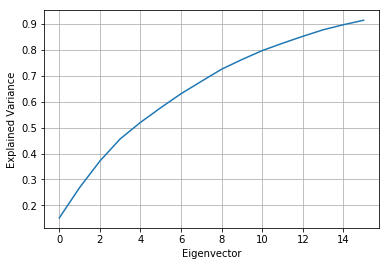

In [34]:
plt.plot(range(16), np.cumsum(pca.explained_variance_ratio_))
plt.grid('on')
plt.xlabel('Eigenvector')
plt.ylabel('Explained Variance')

In [35]:
clusters = kmeans_model.fit_predict(X_pca)

In [36]:
print(f'{list(clusters).count(0)}, {list(clusters).count(1)}, {list(clusters).count(2)}, {list(clusters).count(3)}, {list(clusters).count(4)}, {list(clusters).count(5)}, {list(clusters).count(6)}')

18, 12, 16, 11, 13, 5, 15


In [37]:
pca2d = PCA(n_components=2)
pca_2d = pca2d.fit_transform(X_pca)

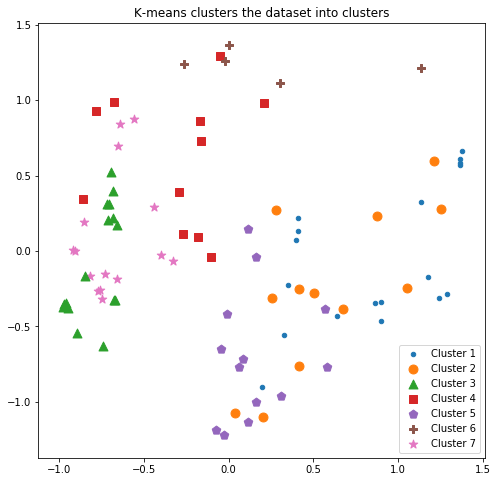

In [38]:
import pylab as pl
pl.figure(figsize=(8,8))

for i in range(0, X_pca.shape[0]):
    if clusters[i] == 0:
        c1 = pl.scatter(pca_2d[i,0], pca_2d[i,1], c='#1f77b4', marker='.', s=80)
    elif clusters[i] == 1:
        c2 = pl.scatter(pca_2d[i,0], pca_2d[i,1], c='#ff7f0e', marker='o', s=80)
    elif clusters[i] == 2:
        c3 = pl.scatter(pca_2d[i,0], pca_2d[i,1], c='#2ca02c', marker='^', s=80)
    elif clusters[i] == 3:
        c4 = pl.scatter(pca_2d[i,0], pca_2d[i,1], c='#d62728', marker='s', s=80)
    elif clusters[i] == 4:
        c5 = pl.scatter(pca_2d[i,0], pca_2d[i,1], c='#9467bd', marker='p', s=80)
    elif clusters[i] == 5:
        c6 = pl.scatter(pca_2d[i,0], pca_2d[i,1], c='#8c564b', marker='P', s=80)
    elif clusters[i] == 6:
        c7 = pl.scatter(pca_2d[i,0], pca_2d[i,1], c='#e377c2', marker='*', s=80)

pl.legend([c1, c2, c3, c4, c5, c6, c7], ['Cluster 1', 'Cluster 2', 'Cluster 3', 'Cluster 4', 'Cluster 5', 'Cluster 6', 'Cluster 7'])
pl.title('K-means clusters the dataset into clusters')
pl.show()

Seems that there are about 3 main clusters.

In [39]:
clusters + 1

array([4, 1, 1, 2, 2, 2, 2, 5, 7, 7, 4, 7, 3, 3, 4, 6, 7, 1, 1, 1, 2, 2,
       2, 2, 2, 5, 1, 5, 3, 7, 5, 5, 5, 5, 5, 3, 3, 3, 7, 3, 3, 7, 3, 3,
       4, 7, 4, 3, 6, 7, 6, 7, 7, 1, 1, 1, 1, 1, 1, 6, 3, 7, 3, 4, 4, 4,
       4, 3, 7, 6, 1, 1, 1, 1, 2, 2, 2, 5, 5, 5, 5, 5, 3, 4, 4, 7, 7, 3,
       1, 1])

In [40]:
len(clusters)

90

In [41]:
len(X)

90

In [42]:
X.order_id.values

array([511353667, 513486993, 513506080, 514329317, 514472097, 514529424,
       514583822, 515363895, 519501788, 519525238, 520119333, 520130914,
       520779953, 520803608, 521095118, 521770033, 521804862, 522420188,
       522542767, 522574215, 522779155, 523294848, 523317944, 523328731,
       523514188, 524196111, 524421347, 524442000, 525397783, 525550553,
       434603220, 434609975, 434617535, 434708231, 434752383, 435005397,
       435006071, 435011399, 435067253, 435171863, 446744761, 446798723,
       447019409, 447020385, 447074978, 447079489, 447091085, 447381509,
       447441456, 447497220, 447523773, 447558662, 447647574, 447877104,
       447986271, 447986377, 448003813, 448008007, 448041560, 448169651,
       359420117, 359644089, 359970875, 359978168, 359978861, 360000762,
       360057302, 360336485, 360402335, 360543623, 360778622, 360790021,
       360802830, 360862630, 361304992, 361326979, 361369624, 361723648,
       361772528, 361776660, 361815160, 361881265, 

In [43]:
pairs = []
order_ids = list(X.order_id.values)

for idx in range(len(X)):
    pairs.append((order_ids[idx], clusters[idx]))

In [44]:
cluster_tables = {}
for cluster in range(7):
    cluster_tables[cluster] = [order_id for order_id, label in pairs if label == cluster]

In [45]:
for cluster in range(7):
    print("Table labeled as {}: {}".format(cluster + 1, cluster_tables[cluster][0]))

Table labeled as 1: 513486993
Table labeled as 2: 514329317
Table labeled as 3: 520779953
Table labeled as 4: 511353667
Table labeled as 5: 515363895
Table labeled as 6: 521770033
Table labeled as 7: 519501788


------

In [46]:
FAMILY_EVENT = "FAMILY_EVENT"
DRINKING = "DRINKING"
BREAKFAST = "BREAKFAST"
LUNCH = "LUNCH"
DINNER = "DINNER"
SOCIAL_GATHERING = "SOCIAL_GATHERING"
AFTER_WORK = "AFTER_WORK"
UNK = "UNKNOWN"


class Bin3to5Classifier:
    def __init__(self):
        pass
    
    def _ToD(self, hour):
        if hour >= 6 and hour < 11:
            return BREAKFAST
        elif hour >= 11 and hour <= 14:
            return LUNCH
        elif hour >= 16 and hour <= 22:
            return DINNER
        
        return UNK
    
    def _is_after_work(self, day, hour):
        if day in ["Saturday", "Sunday"]:
            return False
        if hour >= 15 and hour < 19:
            return True
        return False
    
    def classify(self, table):
        if table["kids_meal"].iloc[0]:
            return FAMILY_EVENT

        if table["total_orders_category_id_3.0"].iloc[0] > 0 and table["total_orders_category_id_2.0"].iloc[0] == 0:
            return DRINKING
        
        if table["sharable"].iloc[0] and \
                (table["total_large_meals"].iloc[0] - table["total_large_sharable_meals"].iloc[0]) < (table["guest_count"].iloc[0] - 1):
            if self._is_after_work(table["order_day_of_week"].iloc[0], table["order_hour"].iloc[0]):
                return AFTER_WORK
            return SOCIAL_GATHERING
        
        if table["total_orders_category_id_2.0"].iloc[0] >= (table["guest_count"].iloc[0] / 2):
            return self._ToD(table["order_hour"].iloc[0])
        
        return UNK

In [47]:
classifier = Bin3to5Classifier()

In [48]:
cluster_pred_labels = {}
for cluster in range(7):
    cluster_pred_labels[cluster] = [classifier.classify(df_orig[df_orig.order_id == table]) \
                                    for table in cluster_tables[cluster]]

for cluster in range(7):
    print("Labels for Cluster {}: {}\n".format(cluster + 1, cluster_pred_labels[cluster]))

Labels for Cluster 1: ['DINNER', 'FAMILY_EVENT', 'UNKNOWN', 'FAMILY_EVENT', 'FAMILY_EVENT', 'FAMILY_EVENT', 'LUNCH', 'FAMILY_EVENT', 'DINNER', 'FAMILY_EVENT', 'FAMILY_EVENT', 'DINNER', 'LUNCH', 'LUNCH', 'FAMILY_EVENT', 'AFTER_WORK', 'LUNCH', 'FAMILY_EVENT']

Labels for Cluster 2: ['LUNCH', 'FAMILY_EVENT', 'SOCIAL_GATHERING', 'SOCIAL_GATHERING', 'DRINKING', 'FAMILY_EVENT', 'FAMILY_EVENT', 'LUNCH', 'DINNER', 'FAMILY_EVENT', 'FAMILY_EVENT', 'FAMILY_EVENT']

Labels for Cluster 3: ['SOCIAL_GATHERING', 'LUNCH', 'LUNCH', 'LUNCH', 'LUNCH', 'LUNCH', 'UNKNOWN', 'LUNCH', 'LUNCH', 'LUNCH', 'LUNCH', 'LUNCH', 'LUNCH', 'SOCIAL_GATHERING', 'BREAKFAST', 'LUNCH']

Labels for Cluster 4: ['UNKNOWN', 'DINNER', 'DRINKING', 'AFTER_WORK', 'DINNER', 'FAMILY_EVENT', 'UNKNOWN', 'DINNER', 'DINNER', 'UNKNOWN', 'AFTER_WORK']

Labels for Cluster 5: ['BREAKFAST', 'LUNCH', 'DINNER', 'LUNCH', 'FAMILY_EVENT', 'DRINKING', 'DINNER', 'UNKNOWN', 'DINNER', 'DINNER', 'SOCIAL_GATHERING', 'DINNER', 'DRINKING']

Labels for Clust

Nothing meaningful.

----